In [1]:
import sys
sys.path.append('..')  # Add the parent directory to the Python path
from ImportFile import *
import matplotlib as mpl
import matplotlib.animation as animation
%matplotlib inline
mpl.rcParams.update({'font.size': 20})
mpl.rcParams.update({'axes.titlesize': 25})
mpl.rcParams.update({'axes.labelsize': 25})

## Plot $u(x,y,\phi)$, its components $u_{abs}$ and $u_{sca}$ and the respective residuals

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
#model = torch.load("../models/RayleighOnly_fixed_lxlynorm_lowBC01_4+2x64_400x50_2/TrainedModel/model.pkl", map_location=Ec.dev)
model = torch.load("../models/RayleighOnly_lxlynorm_lowBC01_4+2x64_400x50_3/TrainedModel/model.pkl", map_location=Ec.dev)

In [3]:
#fig, ax = plt.subplots(dpi=150)

def plotting(i, model=model, images_path='', ax=None, plots=np.array([True,False,False])):
    #model.cpu()
    #model = model.eval()
    n = 101

    x = np.linspace(-1.0, 1.0, n)
    y = np.linspace(-1.0, 1.0, n)

    inputs = torch.from_numpy(np.transpose([np.repeat(x, len(y)), np.tile(y, len(x))])).type(torch.FloatTensor)
    # print(inputs.shape)
    
    # Adjust parameters here
    # All must be normalized!
    #mu = torch.cat([torch.linspace(0,1,50), torch.linspace(-1,0,50)])
    mu = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0, -0.75, -0.5, -0.25]) # (mu = phi)
    mu = mu[i].unsqueeze(0)
    print(mu)
    R_pl = torch.tensor([0.0])
    a = torch.tensor([0.0])
    rayScat = torch.tensor([1.4, (0.1 - 0.5*0.3) / (0.5*0.3)])
        
    params = torch.cat([mu,R_pl,a,rayScat], dim=-1).float().repeat(n**2,1)
    inputs = torch.cat((inputs, params), dim=1).to(Ec.dev)
    
    # print(inputs.shape)
    sol = model(inputs)#[:,1].unsqueeze(1)
    sol_abs = sol[:,0].unsqueeze(1)
    sol = sol[:,1].unsqueeze(1)
    sol_abs = sol_abs.reshape(x.shape[0], y.shape[0]).cpu()
    sol = sol.reshape(x.shape[0], y.shape[0]).cpu()

    x_l = inputs[:, 0]
    y_l = inputs[:, 1]

    levels = np.linspace(-0.00, 1.00, 21)

    num_plots = plots.sum()
    if num_plots == 0:
        num_plots += 1
    fig, ax = plt.subplots(1, num_plots, figsize=(5*num_plots,5), dpi=200, squeeze=False)
    ax = ax[0,:]
    i_ax = 0
    print(ax.shape)
    
    if False:
        #ax.figure(1)
        pcm = ax.pcolormesh(x.reshape(-1, ), y.reshape(-1, ), (sol).detach().numpy().T, cmap='viridis', vmin=0.0, vmax=0.2)#, levels=levels)#, norm=norml)
        if i == -1:
            fig.colorbar(mappable=pcm, ax=ax)
        ax.set_aspect('equal')
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_title(r'$du(x,y,\theta='+f'{mu.item():.2f}'+r'\pi)$ with scattering')
    
    if plots[0]:
        #ax[i_ax].figure(1, dpi=200)
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), (sol_abs+sol).detach().numpy().T, cmap='viridis', vmin=0.0, vmax=1.0)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        #cb.ax.set_title(r'$[sr^{-1}]$', fontsize=16)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_ylabel(r'$y$')
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        ax[i_ax].set_title(r'$u_{tot}(x,y,\phi=0)$')
        #plt.savefig(images_path + f'u1+u2_rayScat=14_theta={mu.item():.2f}.png')
        #plt.show()
        #plt.clf()
        i_ax += 1
    
    if plots[1]:
        #ax[i_ax].figure(2, dpi=200)
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), sol_abs.detach().numpy().T, cmap='viridis', vmin=0.0, vmax=1.0)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        #cb.ax.set_title(r'$[sr^{-1}]$', fontsize=16)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        if i_ax == 0:
            ax[i_ax].set_ylabel(r'$y$')
        else:
            ax[i_ax].set_yticklabels(())
        ax[i_ax].set_title(r'$u_{a}(x,y,\phi=0)$')
        #plt.savefig(images_path + f'u1_rayScat=14_theta={mu.item():.2f}.png')
        #plt.show()
        #plt.clf()
        i_ax += 1
        
    if plots[2]:
        #ax[i_ax].figure(3, dpi=200)
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), sol.detach().numpy().T, cmap='viridis')#, vmin=0.0)#, vmax=1.0)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)#, ticks=(0,0.05,0.10,0.15))
        #cb.ax.set_title(r'$[sr^{-1}]$', fontsize=16)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        if i_ax == 0:
            ax[i_ax].set_ylabel(r'$y$')
        else:
            ax[i_ax].set_yticklabels(())
        ax[i_ax].set_title(r'$u_{s}(x,y,\phi=0)$')
        #plt.savefig(images_path + f'u2_rayScat=14_theta={mu.item():.2f}.png')
        #plt.savefig('u_scat-u_abs_nn.png')
        #plt.show()
        #plt.clf()

    if i_ax != 0:
        cb.set_label(r'Normalized Radiant Intensity $[sr^{-1}]$', fontsize=16, rotation=270, labelpad=20)
    
    if i_ax == 0:
        radii = Ec.r_isotherm(10**(a.unsqueeze(1)*0.35+7.1), (R_pl.unsqueeze(1)*0.95+0.1)*Ec.r_jup_mean, gpu=False)
        print(radii.shape)
        r0_train  =  radii[0,0]
        r99_train = radii[0,-1]
        r = Ec.radius(inputs[:,0].cpu(),inputs[:,1].cpu(),r0_train,r99_train)
        print(r.shape)
        
        real_rayScat = (rayScat[:1].unsqueeze(1) * Ec.std_rayScat) + Ec.mean_rayScat.unsqueeze(0)
        # print(radii.shape, real_rayScat.shape, r.shape)
        real_rayScat = Ec.two_value_interpolation(radii.repeat((r.shape[0],1)), real_rayScat.repeat((r.shape[0],1)), r.unsqueeze(1)).detach()
        real_rayScat = 10.0 ** real_rayScat[:,0].unsqueeze(1)
        
        #real_log_alpha = alphas * Ec.std_alphas + Ec.mean_alphas
        #alphas = Ec.two_value_interpolation(radii.repeat((r.shape[0],1)), real_log_alpha.unsqueeze(0).repeat((r.shape[0],1)), r.unsqueeze(1)).detach()
        #alphas = 10.0**alphas[:,0].unsqueeze(1) + real_rayScat
        alphas = real_rayScat
        alphas *= torch.sqrt(r0_train**2 - r99_train**2)
        alphas = alphas.reshape(x.shape[0], y.shape[0])
        alphas = torch.log10(alphas)
        print(alphas.shape)

        #levels = np.linspace(-10.0, 0.0, 21)
        #z_l = inputs[:, -1].reshape(x.shape[0], y.shape[0])

        #plt.figure(2, dpi=200)
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), alphas.detach().numpy().T, cmap='viridis', vmin=-3.0, vmax=3.0)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        cb.set_label(r'log$_{10}(\frac{\mathrm{d} \tau}{\mathrm{d} x})$', rotation=270, labelpad=25, fontsize=20)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_ylabel(r'$y$')
        ax[i_ax].set_title(r'Differential optical depth', fontsize=16)
        ax[i_ax].set_xticks((-1,-0.5,0,0.5,1))
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        #plt.show()

    if False:
        scatter_values = Ec.compute_scattering(inputs, model)
        scatter_values = scatter_values.unsqueeze(1).reshape(x.shape[0], y.shape[0]).cpu()
        plt.figure(3, dpi=200)
        plt.pcolormesh(x.reshape(-1, ), y.reshape(-1, ), scatter_values.detach().numpy().T, cmap='viridis')#, vmin=-3.0, vmax=3.0)#, levels=levels)#, norm=norml)
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel(r'$x$')
        plt.ylabel(r'$y$')
        #plt.title(r'$\(\int_{-1}^{1} \Phi(\mu,\mu^{\prime}) u(\mu^{\prime}) \,d\mu^{\prime}\)$')
        plt.title('Scattering Integral')
        plt.show()

    
    plt.tight_layout()
    plt.show()
    #print(i)
    #return sol.detach().numpy().T
    #return inputs, u
    return fig

In [4]:
#plotting(-1, model=model, images_path='');
#anim = animation.FuncAnimation(fig, plotting, frames=100, interval=50, repeat=False)#, save_count=100)
#anim.save('RayleighScatteringDiff_RotatingAngle.gif')

tensor([0.])
(3,)


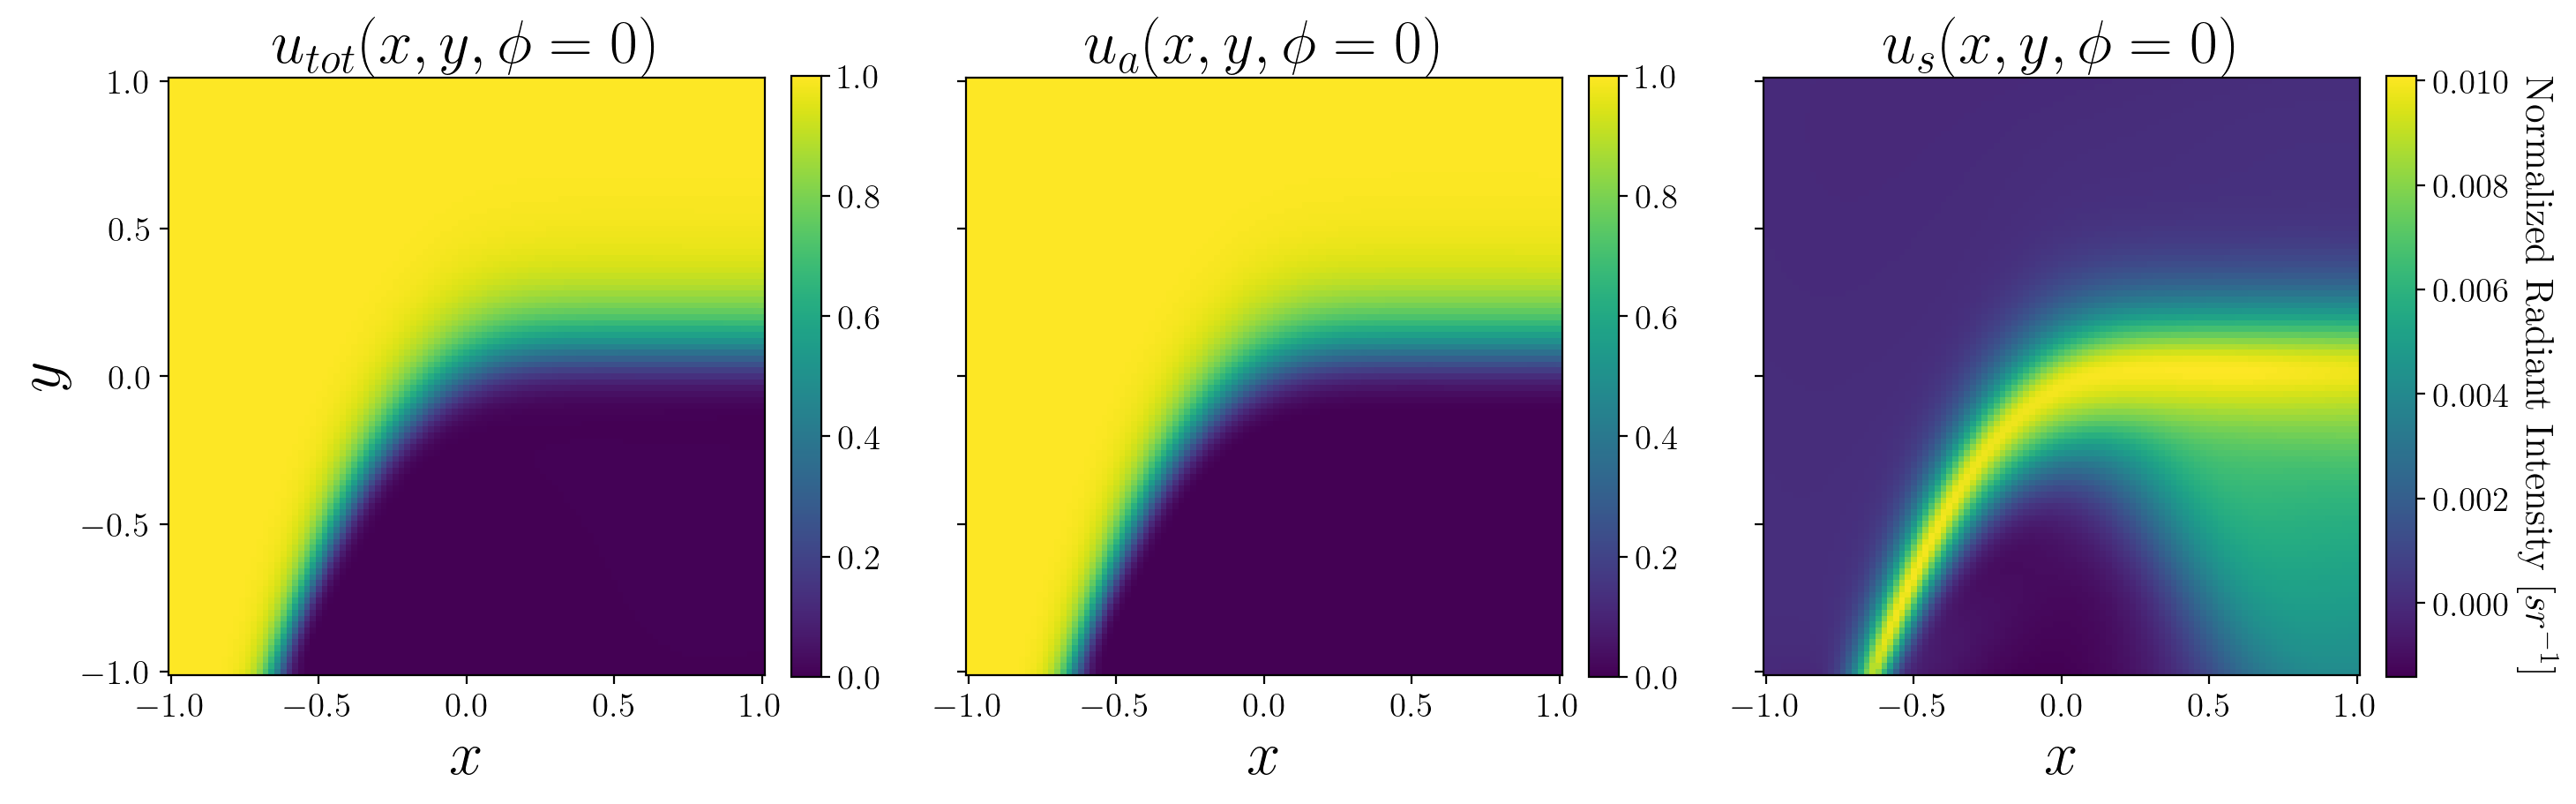

In [14]:
for i in range(1):
    i = 0
    fig = plotting(i, model=model, plots=np.ones(3, dtype=bool))#, images_path='../Downloads/images/RayScat_muMax/');
    #plt.close()

#fig.savefig('../images/sol_alpha=14.png', bbox_inches='tight', pad_inches=0)
#fig.savefig('../images/alpha=14.png', bbox_inches='tight', pad_inches=0, dpi=200)

In [12]:
def plot_res(model=model, images_path='', ax=None, plots=np.array([True,False,False])):
    #model.cpu()
    #model = model.eval()
    n = 101
    ind = 1

    x = np.linspace(-1.0, 1.0, n)
    y = np.linspace(-1.0, 1.0, n)

    inputs = torch.from_numpy(np.transpose([np.repeat(x, len(y)), np.tile(y, len(x))])).type(torch.FloatTensor)
    # print(inputs.shape)
    
    if True:
        mu = torch.tensor([0.0])
        R_pl = torch.tensor([1.05])*Ec.r_jup_mean
        a = 10**torch.tensor([7.1])
        rayScat = torch.tensor([1.4, 0.1])
        #alphas = torch.linspace(-0.5,-0.5,100) * Ec.std_alphas + Ec.mean_alphas
        
        #params = torch.cat([r0_train,r99_train,alpha_train,radii_train], dim=-1).float().repeat(n**2,1)
        params = torch.cat([mu,R_pl,a,rayScat], dim=-1).float().repeat(n**2,1)
        #print(params[0])
        # print(params.shape)

        inputs = torch.cat((inputs, params), dim=1).to(Ec.dev)
        
    else:
        indices = torch.full((n**2,1), ind)# [:,None]
        inputs = torch.cat((inputs, indices), dim=1)

        
    res2_given = True
    if res2_given:
        res = Ec.compute_res(model, inputs, 3, None, False, sample=False)
        res_tot = torch.sqrt(0.5*(res[:,0]**2 + res[:,1]**2)) # sq(MSE(x,y))
        res_tot = res_tot.reshape(x.shape[0], y.shape[0]).cpu().detach().numpy().T
        res2 = res[:,1].reshape(x.shape[0], y.shape[0]).cpu().detach().numpy().T
        res = res[:,0].reshape(x.shape[0], y.shape[0]).cpu().detach().numpy().T
    else:
        res = Ec.compute_res(model, inputs, 3, None, False)
        res = 0.5*(res[:,0] + res[:,1])
        res = res.reshape(x.shape[0], y.shape[0]).cpu()

    x_l = inputs[:, 0]
    y_l = inputs[:, 1]


    levels = np.linspace(-0.00, 1.00, 21)

    fig, ax = plt.subplots(1, plots.sum(), figsize=(5*plots.sum(),5), dpi=200)
    i_ax = 0

    vmin, vmax = (-4.0, -1.0)
    
    if plots[0]:
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), np.log10(abs(res_tot)), cmap='viridis', vmin=vmin, vmax=vmax)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_ylabel(r'$y$')
        ax[i_ax].set_title(r'$\log_{10}\left((res_{abs}^2 + res_{sca}^2)/2 \right)$')
        #plt.show()
        i_ax += 1
    
    if plots[1]:
        #res2[res2<0.0] = 0.0
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), np.log10(abs(res)), cmap='viridis', vmin=vmin, vmax=vmax)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        if i_ax == 0:
            ax[i_ax].set_ylabel(r'$y$')
        else:
            ax[i_ax].set_yticklabels(())
        ax[i_ax].set_title(r'$\log_{10}\left( res_{abs}^2 \right)$')
        #plt.show()
        i_ax += 1

    if plots[2]:
        #res2[res2<0.0] = 0.0
        pcm = ax[i_ax].pcolormesh(x.reshape(-1, ), y.reshape(-1, ), np.log10(abs(res2)), cmap='viridis', vmin=vmin, vmax=vmax)#, levels=levels)#, norm=norml)
        ax[i_ax].set_aspect('equal')
        cb = plt.colorbar(pcm, ax=ax[i_ax], fraction=0.046, pad=0.04)
        ax[i_ax].set_xlabel(r'$x$')
        ax[i_ax].set_yticks((-1,-0.5,0,0.5,1))
        if i_ax == 0:
            ax[i_ax].set_ylabel(r'$y$')
        else:
            ax[i_ax].set_yticklabels(())
        ax[i_ax].set_title(r'$\log_{10}\left( res_{sca}^2 \right)$')
        #plt.show()

    if i_ax != 0:
        cb.set_label(r'Logarithmic Residual Loss [arb.u.]', fontsize=18, rotation=270, labelpad=20)
    
    plt.tight_layout()
    #plt.savefig('../images/res_alpha=14.png', bbox_inches='tight', pad_inches=0, dpi=200)
    plt.show()
    
    return res, res2, res_tot

0.0029, 0.0032


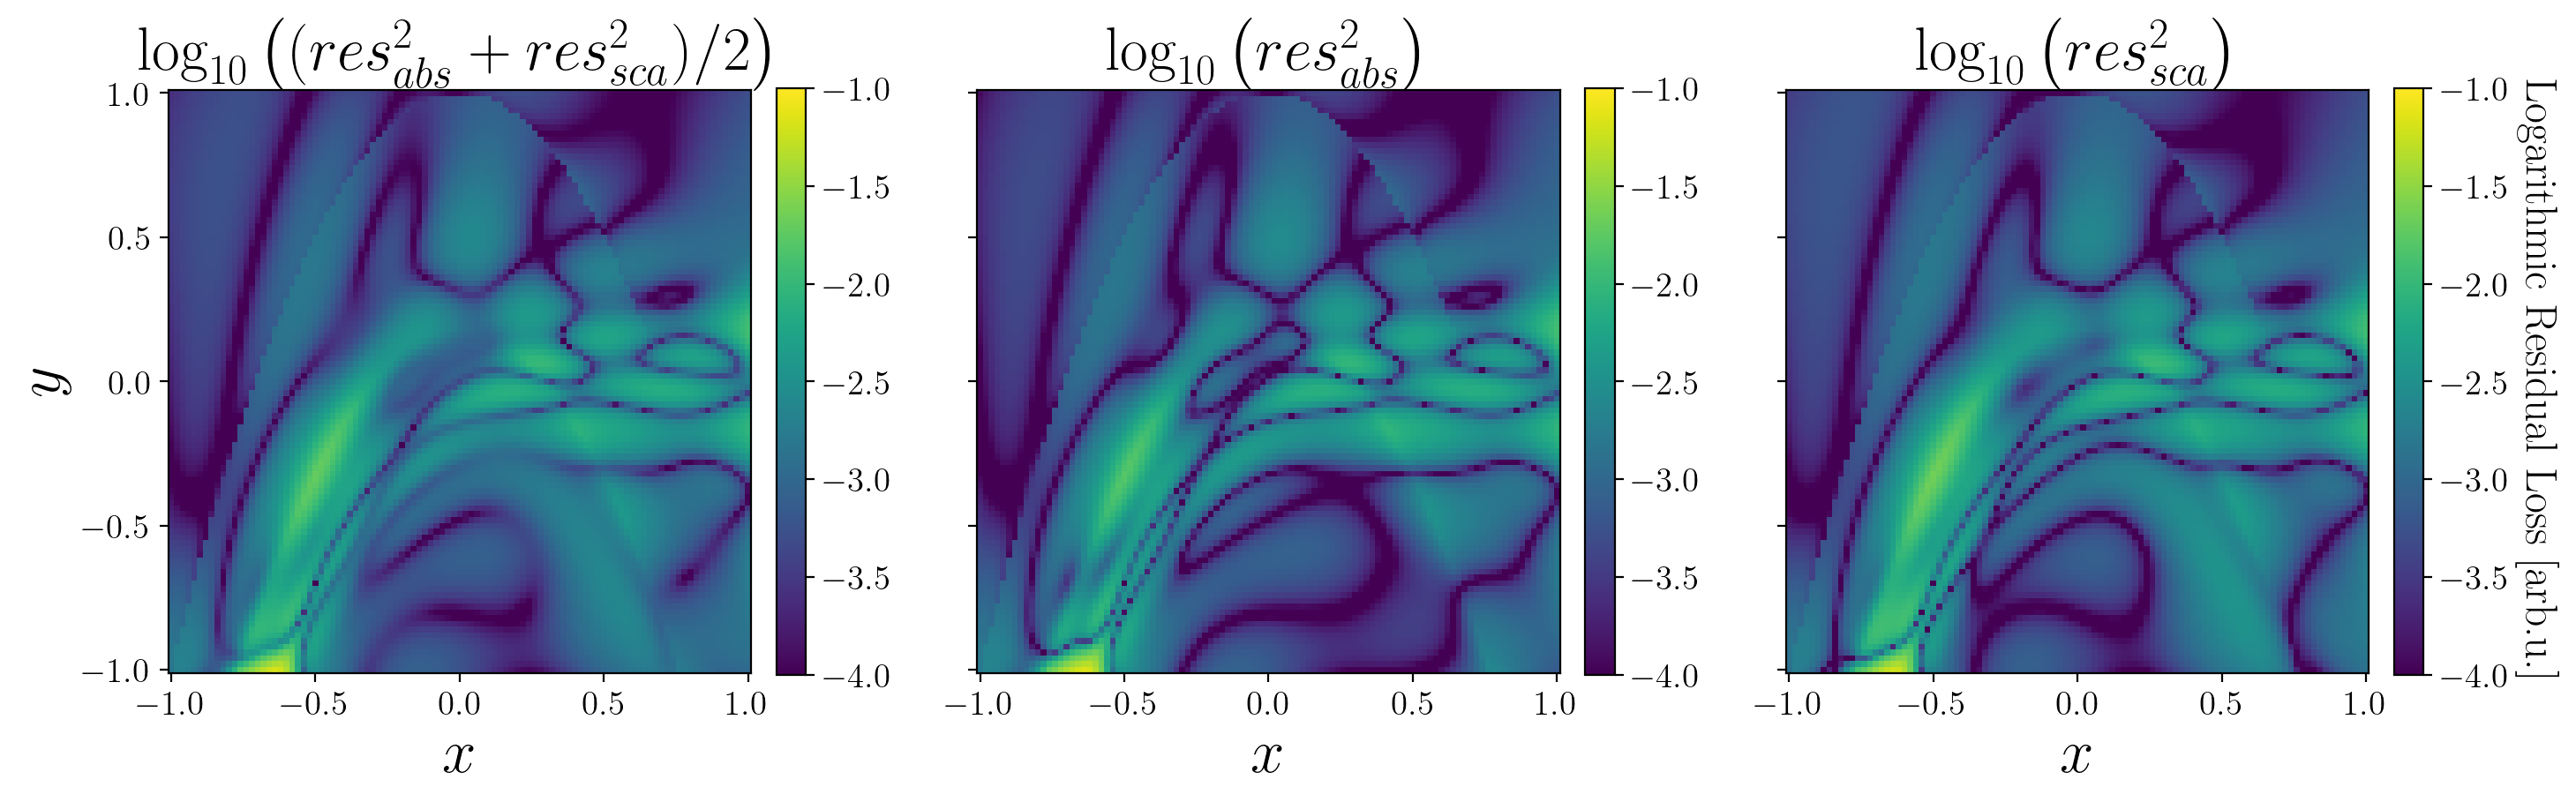

tensor(0.0029)
tensor(0.0032)
tensor(0.0031)


In [13]:
res_abs, res_sca, res_both = torch.tensor(plot_res(plots=np.ones(3, dtype=bool)))
print(torch.sqrt((abs(res_abs)**2).mean()))
print(torch.sqrt((abs(res_sca)**2).mean()))
print(torch.sqrt((abs(res_both)**2).mean()))

In [128]:
def calc_sol(mu, model=model):
    #model.cpu()
    #model = model.eval()
    n = 101
    #ind = np.random.randint(Ec.r0.shape[0])
    #print(ind)
    #ax.clear()

    x = np.linspace(-1.0, 1.0, n)
    y = np.linspace(-1.0, 1.0, n)

    inputs = torch.from_numpy(np.transpose([np.repeat(x, len(y)), np.tile(y, len(x))])).type(torch.FloatTensor)
    # print(inputs.shape)
    
    #r0_train  =  Ec.r0_norm[ind].clone().detach()[None]
    #r99_train = Ec.r99_norm[ind].clone().detach()[None]
    #alpha_train = Ec.norm_alphas[ind,:].clone().detach()
    #radii_train =  Ec.norm_radii[ind,:].clone().detach()
    if False:
        # if radii were generated during training
        radii_train = (radii_train - torch.linspace(1.0, -1.0, 100)) / 0.05
        alpha_train = Ec.real_log_alpha[ind,:].clone().detach()
        alpha_train = (alpha_train - torch.linspace(-18,-6,100)) / torch.linspace(6/2, 10/2, 100)
        alpha_train[alpha_train<-2.0] = -2.0
        
    if True:
        #mu = torch.cat([torch.linspace(0,1,50), torch.linspace(-1,0,50)])
        #mu = torch.tensor([0.0, 0.25, 0.5, 0.75, 1.0, -0.75, -0.5, -0.25])
        #mu = mu[i].unsqueeze(0)
        #mu = torch.tensor([0.0])
        R_pl = torch.tensor([0.0])
        a = torch.tensor([0.0])
        rayScat = torch.tensor([1.4, (0.1 - 0.5*0.3) / (0.5*0.3)])
        # alphas = torch.linspace(-1.5,-1.5,100)
        
    
    #params = torch.cat([r0_train,r99_train,alpha_train,radii_train], dim=-1).float().repeat(n**2,1)
    params = torch.cat([mu,R_pl,a,rayScat], dim=-1).float().repeat(n**2,1)
    #print(params[0])
    # print(params.shape)
    
    inputs = torch.cat((inputs, params), dim=1).to(Ec.dev)
    
    # print(inputs.shape)
    sol = model(inputs)#[:,1].unsqueeze(1)
    sol_abs = sol[:,0].unsqueeze(1)
    sol = sol[:,1].unsqueeze(1)
    sol_abs = sol_abs.reshape(x.shape[0], y.shape[0]).cpu()
    sol = sol.reshape(x.shape[0], y.shape[0]).cpu()

    return sol_abs, sol

In [129]:
mus = torch.linspace(-1.0, 1.0, 29)

u_abs = torch.zeros((101,101,29))
u_sca = torch.zeros((101,101,29))

for i in range(mus.shape[0]):
    
    u_abs_i, u_sca_i = calc_sol(mus[i].unsqueeze(0))

    u_abs[:,:,i] = u_abs_i
    u_sca[:,:,i] = u_sca_i

np.save('../data/u_abs_PINN.npy', u_abs.detach().numpy())
np.save('../data/u_sca_PINN.npy', u_sca.detach().numpy())